In [1]:
# !pip install pytorch-ignite
# !pip install -U sentence-transformers
# from google.colab import drive
# drive.flush_and_unmount()
# drive.mount('/content/drive')

     |████████████████████████████████| 79 kB 3.5 MB/s 
     |████████████████████████████████| 4.0 MB 8.5 MB/s 
     |████████████████████████████████| 1.2 MB 15.4 MB/s 
     |████████████████████████████████| 77 kB 3.7 MB/s 
     |████████████████████████████████| 6.6 MB 40.7 MB/s 
     |████████████████████████████████| 895 kB 38.1 MB/s 
     |████████████████████████████████| 596 kB 37.8 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=169782821ebfab34e023507b9d31c1ade5e78747f182bb08904a44b7503b7494
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [16]:
import torch
import torch.nn.functional as F
from torch import nn

from torch.utils.data.dataloader import default_collate

import matplotlib.pyplot as plt
import os

import numpy as np

from src.datasets.datasets import MovielensDataset
from src.models.mlstm import mLSTM
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import datetime

# datetime object containing current date and time
# script_start_time = datetime.datetime.now().strftime("%Y-%m-%d_%Hh%Mm%S")
script_start_time = '2022-04-14_14h08m44-20220414T184248Z-001/2022-04-14_14h08m44'

find_lr = False

ablation_types = ['movie_network', 'genre', 'user_history', 'user_ratings', 'user_info', 'title']
ablation = None
rnn_type = 'mlstm'

# model

In [4]:
class ScaledEmbedding(nn.Embedding):
    """
    Embedding layer that initialises its values
    to using a normal variable scaled by the inverse
    of the embedding dimension.
    """

    def reset_parameters(self):
        """
        Initialize parameters.
        """

        self.weight.data.normal_(0, 1.0 / self.embedding_dim)
        if self.padding_idx is not None:
            self.weight.data[self.padding_idx].fill_(0)

In [5]:
PADDING_IDX = 0
class mLSTMNet(nn.Module):
    """
    Module representing users through running a recurrent neural network
    over the sequence, using the hidden state at each timestep as the
    sequence representation, a'la [2]_
    During training, representations for all timesteps of the sequence are
    computed in one go. Loss functions using the outputs will therefore
    be aggregating both across the minibatch and across time in the sequence.
    Parameters
    ----------
    num_items: int
        Number of items to be represented.
    embedding_dim: int, optional
        Embedding dimension of the embedding layer, and the number of hidden
        units in the LSTM layer.
    item_embedding_layer: an embedding layer, optional
        If supplied, will be used as the item embedding layer
        of the network.
    References
    ----------
    .. [2] Hidasi, Balazs, et al. "Session-based recommendations with
       recurrent neural networks." arXiv preprint arXiv:1511.06939 (2015).
    """

    def __init__(self, num_items, embedding_dim=32, sparse=False, rnn_type='mlstm', ablation=None):

        super(mLSTMNet, self).__init__()

        self.embedding_dim = embedding_dim

        self.item_embeddings = ScaledEmbedding(num_items, embedding_dim,
                                                padding_idx=PADDING_IDX,
                                                sparse=sparse)

        self.ablation = ablation
        self.rnn_type = rnn_type
        title_dim = 0
        ubranch_dim = 0
        user_history_dim = 0
        movie_dim = 0
        
            

            
            
        if ablation != 'movie_network':
            movie_dim = movie_dim + embedding_dim
        if ablation != 'genre':
            movie_dim = movie_dim + 18
        
        if movie_dim > 0:
            self.mbranch = nn.Sequential(
                nn.Linear(movie_dim, movie_dim),
                nn.ReLU(movie_dim),
                nn.Dropout(0.5),
                
                nn.Linear(movie_dim, movie_dim),
                nn.ReLU(movie_dim),
                nn.Dropout(0.5),
                
                nn.Linear(movie_dim, movie_dim),
                nn.ReLU(movie_dim),
            )
        
        if ablation != 'title':
            title_input_dim = 384
            title_dim = title_input_dim // 2
            self.tbranch = nn.Sequential(                
                nn.Linear(title_input_dim, title_dim),
                nn.ReLU(title_dim),
            )

            
        if ablation != 'user_info':
            ubranch_dim = 21 + 1 + 2 
            self.ubranch = nn.Sequential(
                nn.Linear(ubranch_dim, ubranch_dim),
                nn.ReLU(ubranch_dim),
                nn.Dropout(0.5),
                
                nn.Linear(ubranch_dim, ubranch_dim),
                nn.ReLU(ubranch_dim),
                nn.Dropout(0.5),
                
                nn.Linear(ubranch_dim, ubranch_dim),
                nn.ReLU(ubranch_dim),
            )
            
        
        if ablation != 'user_history':
            
            if ablation != 'user_ratings':
                user_history_dim = embedding_dim+1
            else:
                user_history_dim = embedding_dim
                
            h_init = torch.zeros(user_history_dim)
            h_init.normal_(0, 1.0 / self.embedding_dim)
            self.h_init = nn.Parameter(h_init, requires_grad=True)
            if self.rnn_type == 'mlstm':

                self.mlstm = mLSTM(input_size=user_history_dim,
                                   hidden_size=user_history_dim)
            else:
                self.lstm = nn.LSTM(
                    input_size=user_history_dim,
                    hidden_size=user_history_dim,
                    batch_first=True
                )

            
        self.user_history_dim = user_history_dim
            

        ## THIS IS IRRELEVANT - just for making an ratings output
        ################################################################################################
        concat_dim = user_history_dim+ubranch_dim+movie_dim+title_dim
        self.rating  = nn.Sequential(
            # nn.Dropout(0.5),
            # nn.Linear(user_history_dim+ubranch_dim+movie_dim+title_dim, embedding_dim),
            # nn.ReLU(embedding_dim),
            # nn.Dropout(0.5),
            # nn.Linear(embedding_dim, 1)
            
            
            
            nn.Dropout(0.5),
            
            nn.Linear(concat_dim, concat_dim // 2),
            nn.ReLU(concat_dim // 2),
            nn.Dropout(0.5),
            
            nn.Linear(concat_dim // 2, concat_dim // 2),
            nn.ReLU(concat_dim // 2),
            nn.Dropout(0.5),
            
            
            nn.Linear(concat_dim // 2, 1)
        )
        
    
    def ablate(self, ablation_eval=()):
        if 'movie' in ablation_eval:
            self.mbranch.requires_grad_(False)
            self.mbranch.apply(self._ablate_weights)
        
        if 'title' in ablation_eval:
            self.tbranch.requires_grad_(False)
            self.tbranch.apply(self._ablate_weights)
        
        if 'user_info' in ablation_eval:
            self.ubranch.requires_grad_(False)
            self.ubranch.apply(self._ablate_weights)
            
        if 'user_history' in ablation_eval:
            if self.rnn_type == 'mlstm':
                self.mlstm.requires_grad_(False)
                self.mlstm.lstm_cell.weight_ih.data.fill_(0.0)
                self.mlstm.lstm_cell.weight_hh.data.fill_(0.0)
                
                self.mlstm.lstm_cell.bias_ih.data[self.user_history_dim:2*self.user_history_dim].fill_(-float('inf'))
                self.mlstm.lstm_cell.bias_hh.data[self.user_history_dim:2*self.user_history_dim].fill_(-float('inf'))
                

            elif self.rnn_type =='lstm':
                self.lstm.requires_grad_(False)
                self.lstm.weight_ih_l0.data.fill_(0.0)
                self.lstm.weight_hh_l0.data.fill_(0.0)
                
                self.lstm.bias_ih_l0.data[self.user_history_dim:2*self.user_history_dim].fill_(-float('inf'))
                self.lstm.bias_hh_l0.data[self.user_history_dim:2*self.user_history_dim].fill_(-float('inf'))
        
    def _ablate_weights(self, m):
        if isinstance(m, nn.Linear):
            m.weight.data.fill_(0.0)
            
    def forward(self, item_sequences=None, ratings_sequences=None, lengths=None, movies=None, user_info=None, mgenre=None, mtitle=None):
        """
        Compute user representation from a given sequence.
        Returns
        -------
        tuple (all_representations, final_representation)
            The first element contains all representations from step
            -1 (no items seen) to t - 1 (all but the last items seen).
            The second element contains the final representation
            at step t (all items seen). This final state can be used
            for prediction or evaluation.
        """
        

        if self.ablation != 'movie_network':
            movie_embedding = (self.item_embeddings(torch.unsqueeze(movies, 0)).squeeze(0))
            if self.ablation != 'genre':
                mov_emb = torch.cat((movie_embedding, mgenre), dim=1)
            else:            
                mov_emb = movie_embedding


        elif self.ablation != 'genre':
            mov_emb = mgenre

            
        mov_emb = self.mbranch(mov_emb)
        
        # if 'movie' in ablation_eval:
        #     mov_emb = torch.zeros_like(mov_emb)
        

        if self.ablation != 'title':
            tit_emb = self.tbranch(mtitle)
            
            # if 'title' in ablation_eval:
            #     tit_emb = torch.zeros_like(tit_emb)

                
            

        if self.ablation != 'user_info':
            user_emb = self.ubranch(user_info)
            # if 'user_info' in ablation_eval:
            #     user_emb = torch.zeros_like(user_emb)
                
        if self.ablation != 'user_history':
            # Make the embedding dimension the channel dimension
            sequence_embeddings = self.item_embeddings(item_sequences)
            batch_size, seq_len, _ = sequence_embeddings.size()
            embedding_dim = self.h_init.size()[0]
            seq_start = self.h_init.expand(batch_size, embedding_dim)
            # pad from left with initial state
            if self.ablation != 'user_ratings':
                ratings_embedding = (ratings_sequences.unsqueeze(2) -  3)/(1.155*self.embedding_dim)

                X= torch.cat([sequence_embeddings, ratings_embedding], dim=2)
            else:
                X=sequence_embeddings

            if self.rnn_type == 'mlstm':
                X = self.mlstm(X, (seq_start, seq_start))
                user_representations = X.permute(0, 2, 1)[:, :, -1]
            else:
                seq_start = seq_start.unsqueeze(0)

                X = torch.nn.utils.rnn.pack_padded_sequence(X, lengths,enforce_sorted=False, batch_first=True)                
                X, _ = self.lstm(X, (seq_start, seq_start))
                X, _ = torch.nn.utils.rnn.pad_packed_sequence(X, batch_first=True)

                # X = X.contiguous()
                user_representations =  X.permute(0, 2, 1)[:, :, -1] #.view(-1, X.shape[2])
                
            # if 'user_history' in ablation_eval:
            #     user_representations = torch.zeros_like(user_representations)
                


        ## user_representations[:, :, -1] is your user history representation (lstm output - )
        ## make modifications after this point
        ###################################################################################

        # print(movie_embedding.shape, user_representations.shape)
        
        if self.ablation == 'user_info':
            x = torch.cat([user_representations, mov_emb, tit_emb], dim=1)
        elif self.ablation == 'user_history':
            x = torch.cat([user_emb, mov_emb, tit_emb], dim=1)
        elif self.ablation == 'title':
            # for k in [user_representations, user_emb, mov_emb, genr_emb]:
            #     print(k.size())
            x = torch.cat([user_representations, user_emb, mov_emb], dim=1)
        else:
            x = torch.cat([user_representations, user_emb, mov_emb, tit_emb], dim=1)
        return self.rating(x).squeeze(1)


# Run

In [6]:
common_space = {
    'batch_size': 512,
    'learn_rate': 5e-04,
    'l2': 1e-04,
    'n_iter': 20,
    'embedding_dim': 110,
}

space = common_space

batch_size = int(space['batch_size'])
learn_rate = space['learn_rate']
n_iter = int(space['n_iter'])
embedding_dim = int(space['embedding_dim'])
l2 = space['l2']

early_stop_crit = 5
min_epochs = n_iter*0.3+early_stop_crit

In [17]:
save_dir = os.path.join('data','ml-1m-split')
results_folder = os.path.join('results',f'{rnn_type}_ablation-title',f'{ablation}Ablation', 'ml-1m-split', script_start_time)
model_folder = os.path.join('model',f'{rnn_type}_ablation-title',f'{ablation}Ablation', 'ml-1m-split', script_start_time)



# save_dir = os.path.join('/content/drive/MyDrive/ECSE552proj',save_dir)
# results_folder = os.path.join('/content/drive/MyDrive/ECSE552proj',results_folder)
# model_folder = os.path.join('/content/drive/MyDrive/ECSE552proj',model_folder)



if not os.path.isdir(model_folder):
    os.makedirs(model_folder)
    print(model_folder)

if not os.path.isdir(results_folder):
    os.makedirs(results_folder)

load_bools = (ablation != 'user_history', # user_history
              ablation != 'user_info', # user_info
              ablation != 'movie_info', # movie_info
              rnn_type == 'lstm', # lengths
              'post' if rnn_type == 'lstm' else 'pre', #pad
              # None,
              100 if rnn_type == 'mlstm' else 0, # max_history_length
             ) 
train = MovielensDataset(os.path.join(save_dir,'users_train_dfs.h5'), os.path.join(save_dir,'movies_dfs.h5'), *load_bools)
val = MovielensDataset(os.path.join(save_dir,'users_val_dfs.h5'), os.path.join(save_dir,'movies_dfs.h5'), *load_bools)
test = MovielensDataset(os.path.join(save_dir,'users_test_dfs.h5'), os.path.join(save_dir,'movies_dfs.h5'), *load_bools)

In [18]:
dataloader_train = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
dataloader_test = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)
dataloader_val = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)

In [10]:
# for _, sample in enumerate(dataloader_train):
#     one_samp = sample
#     break

In [11]:
# one_samp

In [9]:
print("device is {}!".format(device))

num_items = train.movies_genres_df.index.max()+1


device is cuda!


In [13]:
if find_lr:
    from ignite.handlers import FastaiLRFinder
    from ignite.engine.engine import Engine

    criterion = torch.nn.MSELoss()
    def train_step(engine, sample):
        model.train()
        optimizer.zero_grad()   

        if ablation != 'user_history':
            user_history_movie_id = sample['user_history_movie_id'].to(device)
            if ablation != 'user_ratings':
                user_history_rating = sample['user_history_rating'].to(torch.float32).to(device)
            else:
                user_history_rating = None
        else:
            user_history_movie_id = None
            user_history_rating = None

        movie_id = sample['movie_id'].to(device)
        rating = sample['rating'].to(device)

        if ablation != 'genre':
            mgenre = sample['movie_info_genres'].to(device)
        else:
            mgenre = None

        if ablation != 'user_info':
            user_info = sample['user_info'].to(device)
        else:
            user_info = None

        if ablation != 'title':
            mtitle = sample['movie_info_title'].to(device)
        else:
            mtitle = None
            
        if rnn_type == 'lstm':
            lengths = sample['user_history_len_cut'].cpu()
        else:
            lengths = None

        # with torch.cuda.amp.autocast():
        #     pred = model(user_history_movie_id, movie_id)

        #     loss = criterion(pred, rating.to(torch.float16))

        pred = model(item_sequences=user_history_movie_id,
                      ratings_sequences=user_history_rating,
                      lengths=lengths,
                      movies=movie_id,
                      user_info=user_info,
                      mgenre=mgenre,
                      mtitle=mtitle,
                    ablation_eval=())

        loss = torch.sqrt(criterion(pred, rating.to(torch.float32)))


        loss.backward()
        optimizer.step()

        return loss.item()

    trainer = Engine(train_step)


    model = mLSTMNet(
        num_items,
        embedding_dim=embedding_dim,
        rnn_type=rnn_type,
        ablation=ablation)

    model.to(device)
    optimizer = torch.optim.AdamW(
                    model.parameters(),
                    weight_decay=l2,
                    lr=1e-06,
                    betas=(0.9, 0.99),
                    eps = 1e-05,
                )



    lr_finder = FastaiLRFinder()
    to_save = {"model": model, "optimizer": optimizer}

    with lr_finder.attach(trainer, to_save=to_save, diverge_th=5.0, end_lr=20) as trainer_with_lr_finder:
        trainer_with_lr_finder.run(dataloader_train)

    # Get lr_finder results
    lr_finder.get_results()
    plt.savefig(os.path.join(results_folder, 'lr_finder.png'))

    # Plot lr_finder results (requires matplotlib)
    lr_finder.plot()

    # get lr_finder suggestion for lr
    learn_rate = lr_finder.lr_suggestion()
    print(learn_rate)
    with open(os.path.join(results_folder, 'lr_finder.txt'), 'a') as the_file:
        the_file.write(str(learn_rate))



In [20]:

criterion = torch.nn.MSELoss()
model = mLSTMNet(
    num_items,
    embedding_dim=embedding_dim,
    rnn_type=rnn_type,
    ablation=ablation)

model.to(device)
optimizer = torch.optim.AdamW(
                model.parameters(),
                weight_decay=l2,
                lr=learn_rate,
                        betas=(0.9, 0.99),
                    eps = 1e-05,
            )


scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learn_rate, pct_start=0.05, div_factor=2, final_div_factor=1, epochs=n_iter, steps_per_epoch=len(dataloader_train))

scaler = torch.cuda.amp.GradScaler()

In [10]:
def compute_acc(dataloader, model):
    loss_running = []
    accu_running = []
    mean_weights = []
    model.eval()
    with torch.no_grad():
        for _, sample in enumerate(dataloader):
            if ablation != 'user_history':
                user_history_movie_id = sample['user_history_movie_id'].to(device)
                if ablation != 'user_ratings':
                    user_history_rating = sample['user_history_rating'].to(torch.float32).to(device)
                else:
                    user_history_rating = None
            else:
                user_history_movie_id = None
                user_history_rating = None

            movie_id = sample['movie_id'].to(device)
            rating = sample['rating'].to(device)

            if ablation != 'genre':
                mgenre = sample['movie_info_genres'].to(device)
            else:
                mgenre = None

            if ablation != 'user_info':
                user_info = sample['user_info'].to(device)
            else:
                user_info = None

            if ablation != 'title':
                mtitle = sample['movie_info_title'].to(device)
            else:
                mtitle = None
                
            if rnn_type == 'lstm':
                lengths = sample['user_history_len_cut'].cpu()
            else:
                lengths = None

            # with torch.cuda.amp.autocast():
            #     pred = model(user_history_movie_id, movie_id)

            #     loss = criterion(pred, rating.to(torch.float16))

            pred = model(item_sequences=user_history_movie_id,
                         ratings_sequences=user_history_rating,
                         lengths=lengths,
                         movies=movie_id,
                         user_info=user_info,
                         mgenre=mgenre,
                         mtitle=mtitle,)
            pred_rounded = torch.clamp(pred,1,5).round()



            loss = criterion(pred, rating.to(torch.float32))
            accu = torch.sum(pred_rounded == rating.to(torch.int32)).to(torch.float32) / len(movie_id)
            loss_running.append(loss.item())
            accu_running.append(accu.item())

            # we will weight average by batch size later
            mean_weights.append(len(movie_id))

    # print(len(loss_running), len(mean_weights))
    return np.average(loss_running, weights=mean_weights), np.average(accu_running, weights=mean_weights)
       

In [16]:
from tqdm.autonotebook import tqdm

Initialize lists to store loss and accuracy values
loss_history = []
loss_history_val = []

accu_history = []
accu_history_val = []

loss_history_running = []
accu_history_running = []
lr_history_running = []

# Early Stopping
best_loss_val = np.inf
early_stop_count = 0


# Train
print("Start train...")
outer = tqdm(total=n_iter, desc='Epochs', position=0)
inner = tqdm(total=len(dataloader_train), desc=f'Batch', position=1)
for epoch in range(n_iter):

    # check to see if validation loss has plateau'd
    if early_stop_count >= early_stop_crit and epoch > min_epochs:
        print(f'Validation loss plateaud; failed to improve after {early_stop_count} at {epoch}th epoch')
        checkpoint = { 
            'epoch': epoch,
            'model': model,
            'optimizer': optimizer,
            'scheduler': scheduler,
            'scaler': scaler}
        torch.save(checkpoint, os.path.join(model_folder, f'checkpt_earlystop_{epoch}.pth'))
        break
    
    early_stop_count += 1
    
    #Train mode
    model.train()
    loss_running = []
    accu_running = []
    mean_weights = []
    
    inner.refresh()  #force print final state
    inner.reset()  #reuse bar    
    for _, sample in enumerate(dataloader_train):
        lr_history_running.append(scheduler.get_last_lr())
        
        
        optimizer.zero_grad()
        if ablation != 'user_history':
            user_history_movie_id = sample['user_history_movie_id'].to(device)
            if ablation != 'user_ratings':
                user_history_rating = sample['user_history_rating'].to(torch.float32).to(device)
            else:
                user_history_rating = None
        else:
            user_history_movie_id = None
            user_history_rating = None

        movie_id = sample['movie_id'].to(device)
        rating = sample['rating'].to(device)

        if ablation != 'genre':
            mgenre = sample['movie_info_genres'].to(device)
        else:
            mgenre = None

        if ablation != 'user_info':
            user_info = sample['user_info'].to(device)
        else:
            user_info = None

        if ablation != 'title':
            mtitle = sample['movie_info_title'].to(device)
        else:
            mtitle = None

        if rnn_type == 'lstm':
            lengths = sample['user_history_len_cut'].cpu()
        else:
            lengths = None

        # with torch.cuda.amp.autocast():
        #     pred = model(user_history_movie_id, movie_id)

        #     loss = criterion(pred, rating.to(torch.float16))

        pred = model(item_sequences=user_history_movie_id,
                     ratings_sequences=user_history_rating,
                     lengths=lengths,
                     movies=movie_id,
                     user_info=user_info,
                     mgenre=mgenre,
                     mtitle=mtitle,)
        
        loss = criterion(pred, rating.to(torch.float32))
        loss_running.append(loss.item())

        pred_rounded = torch.clamp(pred,1,5).round()
        accu = torch.sum(pred_rounded == rating.to(torch.int32)).to(torch.float32) / len(movie_id)
        accu_running.append(accu.item())

        # we will weight average by batch size later
        mean_weights.append(len(movie_id))


        # scaler.scale(loss).backward()
        # scaler.step(optimizer)
        # scaler.update()

        loss.backward()
        optimizer.step()
            # Change the learning rate
        scheduler.step()
        
        inner.update(1)
        
    loss_history.append(np.average(loss_running, weights=mean_weights))
    accu_history.append(np.average(accu_running, weights=mean_weights))
    
    loss_history_running.append(loss_running)
    accu_history_running.append(loss_running)



    # Evaluate mode
    model.eval()
    with torch.no_grad():    
        curr_loss_val, curr_accu_val = compute_acc(dataloader_val, model)
        loss_history_val.append(curr_loss_val)
        accu_history_val.append(curr_accu_val)
    


    # Save the best weights
    if curr_loss_val < best_loss_val:
        best_loss_val = curr_loss_val
        checkpoint = { 
            'epoch': epoch,
            'model': model,
            'optimizer': optimizer,
            'scheduler': scheduler,
            'scaler': scaler}
        torch.save(checkpoint, os.path.join(model_folder, f'best_model.pth'))
        early_stop_count = 0
    
    
    # Save checkpoint every 10
    if epoch % 10 == 0 or epoch >= n_iter-1:
        checkpoint = { 
            'epoch': epoch,
            'model': model,
            'optimizer': optimizer,
            'scheduler': scheduler,
            'scaler': scaler}
        torch.save(checkpoint, os.path.join(model_folder, f'checkpt{epoch}.pth'))
        
    # Print the results    
    outer.update(1)
    print("epoch:", epoch, \
          "train loss:", round(loss_history[-1], 6), \
          "validation loss:", round(loss_history_val[-1], 6), \
            "train accuracy:", round(accu_history[-1], 6), \
          "validation accuracy:", round(accu_history_val[-1], 6),
         "next_lr:", scheduler.get_last_lr())


# Save final model 
checkpoint = { 
    'epoch': epoch,
    'model': model,
    'optimizer': optimizer,
    'scheduler': scheduler,
    'scaler': scaler}
torch.save(checkpoint, os.path.join(model_folder, f'final_model.pth'))

Start train...


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Batch:   0%|          | 0/797 [00:00<?, ?it/s]

epoch: 0 train loss: 1.722066 validation loss: 1.091674 train accuracy: 0.324351 validation accuracy: 0.354512 next_lr: [0.0004999999973099775]
epoch: 1 train loss: 1.028787 validation loss: 1.088415 train accuracy: 0.375009 validation accuracy: 0.361506 next_lr: [0.0004982908918876707]
epoch: 2 train loss: 0.945373 validation loss: 1.003351 train accuracy: 0.391306 validation accuracy: 0.380865 next_lr: [0.0004932187323300366]
epoch: 3 train loss: 0.904155 validation loss: 1.005233 train accuracy: 0.40158 validation accuracy: 0.376151 next_lr: [0.00048492187392767407]
epoch: 4 train loss: 0.881553 validation loss: 1.029933 train accuracy: 0.40748 validation accuracy: 0.373169 next_lr: [0.00047362663334950413]
epoch: 5 train loss: 0.86445 validation loss: 1.01308 train accuracy: 0.412515 validation accuracy: 0.376743 next_lr: [0.0004596411153140045]
epoch: 6 train loss: 0.851772 validation loss: 1.021916 train accuracy: 0.416832 validation accuracy: 0.37865 next_lr: [0.0004433468082956

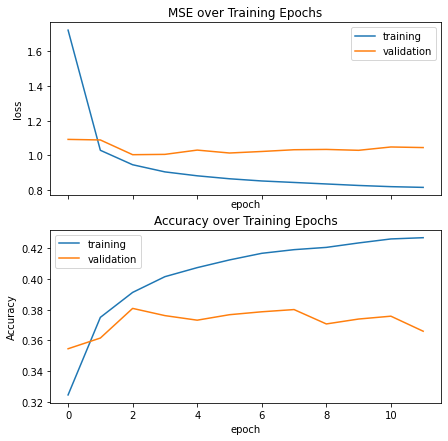

In [17]:
# Print loss history
fig, axs = plt.subplots(2, 1, figsize=(7, 7), squeeze=True, sharex=True)

# loss_history_running = np.concatenate(loss_history_running)
# accu_history_running = np.concatenate(accu_history_running)
# lr_history_running = np.concatenate(lr_history_running)

# n_epochs = len(loss_history_val)
# total_it = len(loss_history_running)

x_epoch = range(len(loss_history_val))
# x_iter = np.linspace(0,n_epochs,total_it,endpoint=False)

axs[0].plot(x_epoch, loss_history, label='training')
axs[0].plot(x_epoch, loss_history_val, label='validation')
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss')
axs[0].set_title('MSE over Training Epochs')
axs[0].legend()

axs[1].plot(x_epoch, accu_history, label='training')
axs[1].plot(x_epoch, accu_history_val, label='validation')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Accuracy over Training Epochs')
axs[1].legend()

# axs[2].plot(x_iter, lr_history_running)
# axs[2].set_xlabel('epoch')
# axs[2].set_ylabel('Learning Rate')
# axs[2].set_title('Learning Rate over Training Epochs')
# axs[2].legend()

plt.savefig(os.path.join(results_folder, 'LossHistory.png'))
plt.show(block=False)

## Evaluate

In [18]:
# checkpoint = torch.load(os.path.join(model_folder, f'best_model.pth'),
#                         map_location=torch.device('cpu'))

# model = checkpoint['model']
# model.to(device)
# model.eval()
# torch.set_grad_enabled(False)


In [22]:
from tqdm.autonotebook import tqdm

def recover_model(checkpoint, criterion, dataloader_train, dataloader_val, n_iter=5):
    
    loss_history = []
    loss_history_val = []

    accu_history = []
    accu_history_val = []
    
    epoch = checkpoint['epoch']
    model = checkpoint['model']
    optimizer = checkpoint['optimizer']
    scheduler = checkpoint['scheduler']
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learn_rate/2, pct_start=0.05, div_factor=2, final_div_factor=1, epochs=n_iter, steps_per_epoch=len(dataloader_train))
    scaler = checkpoint['scaler']
    
    
    best_loss_val = np.inf
    # for param_group in optimizer.param_groups:
    #     param_group['lr'] = lr
    
    print("Start train...")
    outer = tqdm(total=n_iter, desc='Epochs', position=0)
    inner = tqdm(total=len(dataloader_train), desc=f'Batch', position=1)
    for epoch in range(n_iter):

        #Train mode
        model.train()
        loss_running = []
        accu_running = []
        mean_weights = []

        inner.refresh()  #force print final state
        inner.reset()  #reuse bar    
        for _, sample in enumerate(dataloader_train):
            optimizer.zero_grad()
            if ablation != 'user_history':
                user_history_movie_id = sample['user_history_movie_id'].to(device)
                if ablation != 'user_ratings':
                    user_history_rating = sample['user_history_rating'].to(torch.float32).to(device)
                else:
                    user_history_rating = None
            else:
                user_history_movie_id = None
                user_history_rating = None

            movie_id = sample['movie_id'].to(device)
            rating = sample['rating'].to(device)

            if ablation != 'genre':
                mgenre = sample['movie_info_genres'].to(device)
            else:
                mgenre = None

            if ablation != 'user_info':
                user_info = sample['user_info'].to(device)
            else:
                user_info = None

            if ablation != 'title':
                mtitle = sample['movie_info_title'].to(device)
            else:
                mtitle = None

            if rnn_type == 'lstm':
                lengths = sample['user_history_len_cut'].cpu()
            else:
                lengths = None

            # with torch.cuda.amp.autocast():
            #     pred = model(user_history_movie_id, movie_id)

            #     loss = criterion(pred, rating.to(torch.float16))

            pred = model(item_sequences=user_history_movie_id,
                         ratings_sequences=user_history_rating,
                         lengths=lengths,
                         movies=movie_id,
                         user_info=user_info,
                         mgenre=mgenre,
                         mtitle=mtitle,)

            loss = criterion(pred, rating.to(torch.float32))
            loss_running.append(loss.item())

            pred_rounded = torch.clamp(pred,1,5).round()
            accu = torch.sum(pred_rounded == rating.to(torch.int32)).to(torch.float32) / len(movie_id)
            accu_running.append(accu.item())

            # we will weight average by batch size later
            mean_weights.append(len(movie_id))


            # scaler.scale(loss).backward()
            # scaler.step(optimizer)
            # scaler.update()
            # print(loss.device, pred.device, rating.device)

            loss.backward()
            optimizer.step()
                # Change the learning rate
            scheduler.step()

            inner.update(1)

        loss_history.append(np.average(loss_running, weights=mean_weights))
        accu_history.append(np.average(accu_running, weights=mean_weights))



        # Evaluate mode
        model.eval()
        with torch.no_grad():    
            curr_loss_val, curr_accu_val = compute_acc(dataloader_val, model)
            loss_history_val.append(curr_loss_val)
            accu_history_val.append(curr_accu_val)


        # Print the results    
        outer.update(1)
        print("epoch:", epoch, \
              "train loss:", round(loss_history[-1], 6), \
              "validation loss:", round(loss_history_val[-1], 6), \
                "train accuracy:", round(accu_history[-1], 6), \
              "validation accuracy:", round(accu_history_val[-1], 6),
             "next_lr:", scheduler.get_last_lr())
        
        if curr_loss_val < best_loss_val:
            best_loss_val = curr_loss_val
            checkpoint = { 
                'epoch': epoch,
                'model': model,
                'optimizer': optimizer,
                'scheduler': scheduler,
                'scaler': scaler}

        
    return checkpoint


In [23]:
def ablation_anal(checkpoint, ablation_eval, n_iter=5):
    print(ablation_eval)
    
    
    checkpoint['model']
    checkpoint['model'].to(device)
    checkpoint['model'].eval()
    
    checkpoint['model'].ablate(ablation_eval)
    results = []
    results.append(list(compute_acc(dataloader_train, checkpoint['model'])))
    results.append(list(compute_acc(dataloader_val, checkpoint['model'])))
    results.append(list(compute_acc(dataloader_test, checkpoint['model'])))
    
    checkpoint = recover_model(checkpoint, criterion, dataloader_train, dataloader_val, n_iter=n_iter)
    
    checkpoint['model']
    checkpoint['model'].to(device)
    checkpoint['model'].eval()
    
    results_recovered = []
    results_recovered.append(list(compute_acc(dataloader_train, checkpoint['model'])))
    results_recovered.append(list(compute_acc(dataloader_val, checkpoint['model'])))
    results_recovered.append(list(compute_acc(dataloader_test, checkpoint['model'])))
    
    results_df = pd.DataFrame(results, index = ['train','val','test'], columns = ['loss (MSE)', 'accuracy'])
    results_recovered_df = pd.DataFrame(results_recovered, index = ['train','val','test'], columns = ['loss (MSE)', 'accuracy'])
    
    return pd.concat([results_df, results_recovered_df], keys=['ablated', f'recovered {n_iter}'], axis=1)

In [24]:
import pandas as pd

# ablation_evals = ['movie', 'title', 'user_history', 'user_info']
ablation_evals = [
    (),
    ('movie',),
    ('title',),
    ('user_history',),
    ('user_info',),
    ('movie', 'title'),
    # ('movie', 'user_history'),
    # ('movie', 'user_info'),
    # ('title', 'user_history'),
    # ('title', 'user_info'),
    ('user_history', 'user_info'),
    # ('movie', 'title', 'user_history'),
    # ('movie', 'title', 'user_info'),
    # ('movie', 'user_history', 'user_info'),
    # ('title', 'user_history', 'user_info'),
    ('movie', 'title', 'user_history', 'user_info')
    
]



results_dfs = []
for ablation_eval in ablation_evals:
    checkpoint = torch.load(os.path.join(model_folder, f'best_model.pth'),
                        map_location=torch.device(device))
    
    results_df = ablation_anal(checkpoint, ablation_eval, 2)
    results_dfs.append(results_df)
    display(results_df)
    
full_results_df = pd.concat(results_dfs, keys = map(str, ablation_evals) )
full_results_df.index.names = ['ablation', 'set']
full_results_df.to_csv(os.path.join(results_folder, 'results.csv'))

()
Start train...


Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Batch:   0%|          | 0/797 [00:00<?, ?it/s]

epoch: 0 train loss: 0.897004 validation loss: 1.006555 train accuracy: 0.403048 validation accuracy: 0.380404 next_lr: [0.00019253197737664198]
epoch: 1 train loss: 0.880404 validation loss: 1.014696 train accuracy: 0.407613 validation accuracy: 0.379681 next_lr: [0.00012500013450107846]


ablated           recovered 2          
      loss (MSE)  accuracy  loss (MSE)  accuracy
train   0.811013  0.414555    0.791817  0.421203
val     1.003351  0.380865    1.014696  0.379681
test    0.916337  0.388292    0.925138  0.388914

('movie',)
Start train...


Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Batch:   0%|          | 0/797 [00:00<?, ?it/s]

epoch: 0 train loss: 1.00611 validation loss: 1.10669 train accuracy: 0.378112 validation accuracy: 0.37135 next_lr: [0.00019253197737664198]
epoch: 1 train loss: 0.951785 validation loss: 1.075205 train accuracy: 0.39045 validation accuracy: 0.371547 next_lr: [0.00012500013450107846]


ablated           recovered 2          
      loss (MSE)  accuracy  loss (MSE)  accuracy
train   1.027091  0.357619    0.841484  0.409701
val     1.200552  0.341051    1.075205  0.371547
test    1.119700  0.341777    0.972985  0.383191

('title',)
Start train...


Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Batch:   0%|          | 0/797 [00:00<?, ?it/s]

epoch: 0 train loss: 0.914637 validation loss: 1.022329 train accuracy: 0.400197 validation accuracy: 0.380645 next_lr: [0.00019253197737664198]
epoch: 1 train loss: 0.883823 validation loss: 1.015208 train accuracy: 0.407466 validation accuracy: 0.377839 next_lr: [0.00012500013450107846]


ablated           recovered 2          
      loss (MSE)  accuracy  loss (MSE)  accuracy
train   0.899765  0.384471    0.800526  0.416156
val     1.074810  0.363852    1.015208  0.377839
test    1.001546  0.365334    0.937931  0.386052

('user_history',)
Start train...


Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Batch:   0%|          | 0/797 [00:00<?, ?it/s]

epoch: 0 train loss: 1.065375 validation loss: 1.027405 train accuracy: 0.363097 validation accuracy: 0.361023 next_lr: [0.00019253197737664198]
epoch: 1 train loss: 1.051271 validation loss: 1.001619 train accuracy: 0.36564 validation accuracy: 0.372292 next_lr: [0.00012500013450107846]


ablated           recovered 2          
      loss (MSE)  accuracy  loss (MSE)  accuracy
train   0.995826  0.383094    0.980688  0.372227
val     1.009345  0.383145    1.001619  0.372292
test    0.932024  0.399849    0.943935  0.377401

('user_info',)
Start train...


Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Batch:   0%|          | 0/797 [00:00<?, ?it/s]

epoch: 0 train loss: 0.895691 validation loss: 0.998639 train accuracy: 0.403806 validation accuracy: 0.376633 next_lr: [0.00019253197737664198]
epoch: 1 train loss: 0.880375 validation loss: 1.005038 train accuracy: 0.408779 validation accuracy: 0.379681 next_lr: [0.00012500013450107846]


ablated           recovered 2          
      loss (MSE)  accuracy  loss (MSE)  accuracy
train   0.809603  0.415408    0.791295  0.419656
val     1.003404  0.381150    1.005038  0.379681
test    0.916015  0.388692    0.925381  0.387804

('movie', 'title')
Start train...


Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Batch:   0%|          | 0/797 [00:00<?, ?it/s]

epoch: 0 train loss: 1.123108 validation loss: 1.306041 train accuracy: 0.356084 validation accuracy: 0.346225 next_lr: [0.00019253197737664198]
epoch: 1 train loss: 1.096686 validation loss: 1.311702 train accuracy: 0.361298 validation accuracy: 0.343594 next_lr: [0.00012500013450107846]


ablated           recovered 2          
      loss (MSE)  accuracy  loss (MSE)  accuracy
train   1.197563  0.317433    1.015383  0.375970
val     1.348329  0.310576    1.311702  0.343594
test    1.287709  0.302027    1.181127  0.352092

('user_history', 'user_info')
Start train...


Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Batch:   0%|          | 0/797 [00:00<?, ?it/s]

epoch: 0 train loss: 1.063727 validation loss: 0.997816 train accuracy: 0.362965 validation accuracy: 0.375055 next_lr: [0.00019253197737664198]
epoch: 1 train loss: 1.052891 validation loss: 1.00696 train accuracy: 0.365223 validation accuracy: 0.370363 next_lr: [0.00012500013450107846]


ablated           recovered 2          
      loss (MSE)  accuracy  loss (MSE)  accuracy
train   0.994540  0.383751    0.986568  0.370545
val     1.008607  0.384219    1.006960  0.370363
test    0.931320  0.400515    0.950857  0.376669

('movie', 'title', 'user_history', 'user_info')
Start train...


Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Batch:   0%|          | 0/797 [00:00<?, ?it/s]

epoch: 0 train loss: 1.33798 validation loss: 1.262873 train accuracy: 0.305928 validation accuracy: 0.28179 next_lr: [0.00019253197737664198]
epoch: 1 train loss: 1.331609 validation loss: 1.262421 train accuracy: 0.306551 validation accuracy: 0.28179 next_lr: [0.00012500013450107846]


ablated           recovered 2          
      loss (MSE)  accuracy  loss (MSE)  accuracy
train   1.278023  0.273729    1.265568  0.273729
val     1.272282  0.281790    1.262421  0.281790
test    1.193418  0.280777    1.171681  0.280777

In [25]:
full_results_df

ablated            \
                                                      loss (MSE)  accuracy   
ablation                                        set                          
()                                              train   0.811013  0.414555   
                                                val     1.003351  0.380865   
                                                test    0.916337  0.388292   
('movie',)                                      train   1.027091  0.357619   
                                                val     1.200552  0.341051   
                                                test    1.119700  0.341777   
('title',)                                      train   0.899765  0.384471   
                                                val     1.074810  0.363852   
                                                test    1.001546  0.365334   
('user_history',)                               train   0.995826  0.383094   
                                                val     1.009345  0.383145   
                                                test    0.932024  0.399849   
('user_info',)                                  train   0.809603  0.415408   
                                                val     1.003404  0.381150   
                                                test    0.916015  0.388692   
('movie', 'title')                              train   1.197563  0.317433   
                                                val     1.348329  0.310576   
                                                test    1.287709  0.302027   
('user_history', 'user_info')                   train   0.994540  0.383751   
                                                val     1.008607  0.384219   
                                                test    0.931320  0.400515   
('movie', 'title', 'user_history', 'user_info') train   1.278023  0.273729   
                                                val     1.272282  0.281790   
                                                test    1.193418  0.280777   

                                                      recovered 2            
                                                       loss (MSE)  accuracy  
ablation                                        set                          
()                                              train    0.791817  0.421203  
                                                val      1.014696  0.379681  
                                                test     0.925138  0.388914  
('movie',)                                      train    0.841484  0.409701  
                                                val      1.075205  0.371547  
                                                test     0.972985  0.383191  
('title',)                                      train    0.800526  0.416156  
                                                val      1.015208  0.377839  
                                                test     0.937931  0.386052  
('user_history',)                               train    0.980688  0.372227  
                                                val      1.001619  0.372292  
                                                test     0.943935  0.377401  
('user_info',)                                  train    0.791295  0.419656  
                                                val      1.005038  0.379681  
                                                test     0.925381  0.387804  
('movie', 'title')                              train    1.015383  0.375970  
                                                val      1.311702  0.343594  
                                                test     1.181127  0.352092  
('user_history', 'user_info')                   train    0.986568  0.370545  
                                                val      1.006960  0.370363  
                                                test     0.950857  0.376669  
('movie', 'title', 'user_history', 'user_info') train    1.265568  0.273729  


In [29]:
full_results_df.xs('loss (MSE)', level=1, axis=1, drop_level=False).xs('test', level=1, axis=0, drop_level=False)

,,ablated,recovered 2
,,loss (MSE),loss (MSE)
ablation,set,,
(),test,0.916337,0.925138
"('movie',)",test,1.119700,0.972985
"('title',)",test,1.001546,0.937931
"('user_history',)",test,0.932024,0.943935
"('user_info',)",test,0.916015,0.925381
"('movie', 'title')",test,1.287709,1.181127
"('user_history', 'user_info')",test,0.931320,0.950857
"('movie', 'title', 'user_history', 'user_info')",test,1.193418,1.171681


In [26]:
model_folder

'model/mlstm_ablation-title/NoneAblation/ml-1m-split/2022-04-14_14h08m44-20220414T184248Z-001/2022-04-14_14h08m44'

In [30]:
full_results_df.to_csv((os.path.join(results_folder, f'ablation_results{rnn_type}.csv')))